In [ ]:
import av  
import cv2
import mediapipe as mp
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

container = av.open("2025-07-02 11-39-15.mp4")
stream = container.streams.video[0]
fps = float(stream.average_rate) if stream.average_rate else 30  
print(f"Detected FPS from PyAV: {fps}")

width = stream.codec_context.width
height = stream.codec_context.height
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter("2025-07-02 11-39-15_overlay.mov", fourcc, fps, (width, height))

landmark_csv = open("hand_landmarks_01-test-01.csv", mode="w", newline="")
landmark_writer = csv.writer(landmark_csv)
landmark_writer.writerow(["frame", "time_sec", "hand", "landmark_id", "x", "y", "z", "hand_detected"])

summary_csv = open("frame_detection_summary.csv", mode="w", newline="")
summary_writer = csv.writer(summary_csv)
summary_writer.writerow(["frame", "time_sec", "hands_detected", "hand_labels_detected"])

frame_num = 0
frames_with_detection = 0
total_frames = 0

for frame in container.decode(video=0):
    # PyAV frame -> numpy array (RGB)
    img = frame.to_ndarray(format="bgr24")
    time_sec = float(frame.pts * frame.time_base) if frame.pts else frame_num / fps

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    detected_labels = []

    if result.multi_hand_landmarks and result.multi_handedness:
        hands_detected = len(result.multi_hand_landmarks)
        frames_with_detection += 1

        for (hand_landmarks, handedness) in zip(result.multi_hand_landmarks, result.multi_handedness):
            hand_label = handedness.classification[0].label  # 'Left' or 'Right'
            detected_labels.append(hand_label)

            for idx, lm in enumerate(hand_landmarks.landmark):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, lm.x, lm.y, lm.z, 1])

            # Draw with different color
            color = (0, 255, 0) if hand_label == "Left" else (0, 0, 255)
            mp_draw.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=3),
                mp_draw.DrawingSpec(color=color, thickness=2)
            )
    else:
        hands_detected = 0
        for hand_label in ['Left', 'Right']:
            for idx in range(21):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, None, None, None, 0])

    summary_writer.writerow([frame_num, time_sec, hands_detected, ','.join(detected_labels)])

    out.write(img)

    cv2.imshow("Hand Detection VFR", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_num += 1
    total_frames += 1

landmark_csv.close()
summary_csv.close()
out.release()
cv2.destroyAllWindows()

print("-------- Detection Report --------")
print(f"Total frames: {total_frames}")
print(f"Frames with at least 1 hand detected: {frames_with_detection}")
print(f"Detection rate: {frames_with_detection/total_frames:.2%}")

I0000 00:00:1752190974.070677 23236352 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752190974.090003 23238703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752190974.096403 23238703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Detected FPS from PyAV: 60.0


W0000 00:00:1752190977.334580 23238712 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


-------- Detection Report --------
Total frames: 5240
Frames with at least 1 hand detected: 4149
Detection rate: 79.18%


In [1]:
df = pd.read_csv("hand_landmarks_01-test-01.csv")

print("Shape:", df.shape)
df

Shape: (185388, 8)


,frame,time_sec,hand,landmark_id,x,y,z,hand_detected
0,0,0.000000,Left,0,NaN,NaN,NaN,0
1,0,0.000000,Left,1,NaN,NaN,NaN,0
2,0,0.000000,Left,2,NaN,NaN,NaN,0
3,0,0.000000,Left,3,NaN,NaN,NaN,0
4,0,0.000000,Left,4,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
185383,5239,87.333333,Right,16,NaN,NaN,NaN,0
185384,5239,87.333333,Right,17,NaN,NaN,NaN,0
185385,5239,87.333333,Right,18,NaN,NaN,NaN,0
185386,5239,87.333333,Right,19,NaN,NaN,NaN,0


In [2]:
df_wide = df.pivot_table(index=["frame", "time_sec", "hand", "hand_detected"], 
                                columns="landmark_id", 
                                values=["x", "y", "z"])
df_wide.columns = [f"{coord}_{lmk}" for coord, lmk in df_wide.columns]
df_wide = df_wide.reset_index()
df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,139,2.316667,Left,1,0.739851,0.746795,0.743200,0.732768,0.724978,0.733892,...,-0.022694,-0.029364,0.019300,-0.001943,-0.015308,-0.017748,0.023155,0.008353,0.000929,0.000017
1,140,2.333333,Left,1,0.740607,0.752635,0.749488,0.734470,0.726105,0.743083,...,-0.024573,-0.027776,0.018126,-0.004453,-0.016250,-0.016220,0.024569,0.008350,0.001288,0.001831
2,141,2.350000,Left,1,0.739510,0.751147,0.748804,0.734133,0.723349,0.739582,...,-0.015114,-0.021573,0.027649,0.006390,-0.009512,-0.012488,0.031582,0.016049,0.006908,0.005533
3,142,2.366667,Left,1,0.740625,0.757427,0.754611,0.737037,0.721377,0.744787,...,-0.006316,-0.015998,0.041151,0.017248,-0.004651,-0.010568,0.043575,0.026450,0.013843,0.010108
4,143,2.383333,Left,1,0.713443,0.746745,0.755528,0.743631,0.725307,0.753184,...,-0.004695,-0.019736,0.057018,0.030807,-0.000870,-0.012341,0.062581,0.043079,0.023987,0.015717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345,4739,78.983333,Left,1,0.605860,0.577431,0.572069,0.567270,0.560884,0.648888,...,-0.016901,-0.009946,0.008326,0.011651,0.013079,0.015457,0.041377,0.045619,0.046596,0.048374
6346,4740,79.000000,Left,1,0.607172,0.574205,0.569787,0.565997,0.559199,0.645663,...,-0.000199,0.007201,0.019036,0.024805,0.025153,0.026226,0.050519,0.055929,0.055348,0.055539
6347,4741,79.016667,Left,1,0.597536,0.567249,0.564755,0.566291,0.562113,0.643634,...,-0.035401,-0.029069,-0.000321,-0.002598,-0.003430,-0.003016,0.034143,0.032199,0.029066,0.027619
6348,4742,79.033333,Left,1,0.595344,0.563689,0.562409,0.565489,0.562530,0.641024,...,-0.025878,-0.019214,0.006272,0.004897,0.002748,0.002664,0.039182,0.037647,0.033065,0.030840


In [3]:
df_wide['time_sec'] = df_wide['time_sec'].round(3)

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,139,2.317,Left,1,0.739851,0.746795,0.743200,0.732768,0.724978,0.733892,...,-0.022694,-0.029364,0.019300,-0.001943,-0.015308,-0.017748,0.023155,0.008353,0.000929,0.000017
1,140,2.333,Left,1,0.740607,0.752635,0.749488,0.734470,0.726105,0.743083,...,-0.024573,-0.027776,0.018126,-0.004453,-0.016250,-0.016220,0.024569,0.008350,0.001288,0.001831
2,141,2.350,Left,1,0.739510,0.751147,0.748804,0.734133,0.723349,0.739582,...,-0.015114,-0.021573,0.027649,0.006390,-0.009512,-0.012488,0.031582,0.016049,0.006908,0.005533
3,142,2.367,Left,1,0.740625,0.757427,0.754611,0.737037,0.721377,0.744787,...,-0.006316,-0.015998,0.041151,0.017248,-0.004651,-0.010568,0.043575,0.026450,0.013843,0.010108
4,143,2.383,Left,1,0.713443,0.746745,0.755528,0.743631,0.725307,0.753184,...,-0.004695,-0.019736,0.057018,0.030807,-0.000870,-0.012341,0.062581,0.043079,0.023987,0.015717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345,4739,78.983,Left,1,0.605860,0.577431,0.572069,0.567270,0.560884,0.648888,...,-0.016901,-0.009946,0.008326,0.011651,0.013079,0.015457,0.041377,0.045619,0.046596,0.048374
6346,4740,79.000,Left,1,0.607172,0.574205,0.569787,0.565997,0.559199,0.645663,...,-0.000199,0.007201,0.019036,0.024805,0.025153,0.026226,0.050519,0.055929,0.055348,0.055539
6347,4741,79.017,Left,1,0.597536,0.567249,0.564755,0.566291,0.562113,0.643634,...,-0.035401,-0.029069,-0.000321,-0.002598,-0.003430,-0.003016,0.034143,0.032199,0.029066,0.027619
6348,4742,79.033,Left,1,0.595344,0.563689,0.562409,0.565489,0.562530,0.641024,...,-0.025878,-0.019214,0.006272,0.004897,0.002748,0.002664,0.039182,0.037647,0.033065,0.030840


In [4]:
df2 = pd.read_csv("hand_lable_01-test-01.csv")

print("Shape:", df.shape)
df2

Shape: (185388, 8)


,Observation id,Observation date,Description,Observation duration,Observation type,Source,Time offset (s),Media duration (s),FPS,Subject,Behavior,Behavioral category,Behavior type,Time,Media file name,Image index,Image file path,Comment
0,01-2,2025-07-07 00:43:47.739,NaN,79.1,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.333,60.0,1,hold,NaN,START,0.000,D:/Data Science/UOB/DS_project/Full Study/01-2...,0,NaN,NaN
1,01-2,2025-07-07 00:43:47.739,NaN,79.1,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.333,60.0,1,hold,NaN,STOP,10.750,D:/Data Science/UOB/DS_project/Full Study/01-2...,645,NaN,NaN
2,01-2,2025-07-07 00:43:47.739,NaN,79.1,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.333,60.0,1,adjust,NaN,START,10.767,D:/Data Science/UOB/DS_project/Full Study/01-2...,646,NaN,NaN
3,01-2,2025-07-07 00:43:47.739,NaN,79.1,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.333,60.0,1,adjust,NaN,STOP,11.467,D:/Data Science/UOB/DS_project/Full Study/01-2...,688,NaN,NaN
4,01-2,2025-07-07 00:43:47.739,NaN,79.1,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.333,60.0,1,hold,NaN,START,11.483,D:/Data Science/UOB/DS_project/Full Study/01-2...,689,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,01-2,2025-07-07 00:43:47.739,NaN,79.1,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.333,60.0,1,hold,NaN,STOP,74.850,D:/Data Science/UOB/DS_project/Full Study/01-2...,4491,NaN,NaN
74,01-2,2025-07-07 00:43:47.739,NaN,79.1,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.333,60.0,1,place,NaN,START,74.867,D:/Data Science/UOB/DS_project/Full Study/01-2...,4492,NaN,NaN
75,01-2,2025-07-07 00:43:47.739,NaN,79.1,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.333,60.0,1,place,NaN,STOP,78.700,D:/Data Science/UOB/DS_project/Full Study/01-2...,4722,NaN,NaN
76,01-2,2025-07-07 00:43:47.739,NaN,79.1,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,87.333,60.0,1,other,NaN,START,78.717,D:/Data Science/UOB/DS_project/Full Study/01-2...,4723,NaN,NaN


In [5]:
df_sub = df2[['Behavior', 'Behavior type', 'Time', 'Image index']]

df_start = df_sub[df_sub['Behavior type'] == 'START'].copy()
df_stop  = df_sub[df_sub['Behavior type'] == 'STOP'].copy()

df_start = df_start.reset_index(drop=True)
df_stop  = df_stop.reset_index(drop=True)

df_events = pd.DataFrame({
    'behavior': df_start['Behavior'],
    'start_time': df_start['Time'],
    'stop_time': df_stop['Time'],
    'start_image_index': df_start['Image index'],
    'stop_image_index': df_stop['Image index']
})

df_events

,behavior,start_time,stop_time,start_image_index,stop_image_index
0,hold,0.000,10.750,0,645
1,adjust,10.767,11.467,646,688
2,hold,11.483,12.217,689,733
3,press,12.233,12.750,734,765
4,hold,12.767,13.417,766,805
5,hold,17.700,17.850,1062,1071
6,press,17.867,19.117,1072,1147
7,hold,19.133,20.233,1148,1214
8,press,20.250,21.333,1215,1280
9,hold,21.350,21.617,1281,1297


In [6]:
df_wide['behavior'] = np.nan

for _, row in df_events.iterrows():
    b = row['behavior']
    t_start = row['start_time']
    t_stop = row['stop_time']

    mask = (df_wide['time_sec'] >= t_start) & (df_wide['time_sec'] <= t_stop)

    df_wide.loc[mask, 'behavior'] = b

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_26534/222154802.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'hold' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_wide.loc[mask, 'behavior'] = b


,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,139,2.317,Left,1,0.739851,0.746795,0.743200,0.732768,0.724978,0.733892,...,-0.029364,0.019300,-0.001943,-0.015308,-0.017748,0.023155,0.008353,0.000929,0.000017,hold
1,140,2.333,Left,1,0.740607,0.752635,0.749488,0.734470,0.726105,0.743083,...,-0.027776,0.018126,-0.004453,-0.016250,-0.016220,0.024569,0.008350,0.001288,0.001831,hold
2,141,2.350,Left,1,0.739510,0.751147,0.748804,0.734133,0.723349,0.739582,...,-0.021573,0.027649,0.006390,-0.009512,-0.012488,0.031582,0.016049,0.006908,0.005533,hold
3,142,2.367,Left,1,0.740625,0.757427,0.754611,0.737037,0.721377,0.744787,...,-0.015998,0.041151,0.017248,-0.004651,-0.010568,0.043575,0.026450,0.013843,0.010108,hold
4,143,2.383,Left,1,0.713443,0.746745,0.755528,0.743631,0.725307,0.753184,...,-0.019736,0.057018,0.030807,-0.000870,-0.012341,0.062581,0.043079,0.023987,0.015717,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345,4739,78.983,Left,1,0.605860,0.577431,0.572069,0.567270,0.560884,0.648888,...,-0.009946,0.008326,0.011651,0.013079,0.015457,0.041377,0.045619,0.046596,0.048374,other
6346,4740,79.000,Left,1,0.607172,0.574205,0.569787,0.565997,0.559199,0.645663,...,0.007201,0.019036,0.024805,0.025153,0.026226,0.050519,0.055929,0.055348,0.055539,other
6347,4741,79.017,Left,1,0.597536,0.567249,0.564755,0.566291,0.562113,0.643634,...,-0.029069,-0.000321,-0.002598,-0.003430,-0.003016,0.034143,0.032199,0.029066,0.027619,other
6348,4742,79.033,Left,1,0.595344,0.563689,0.562409,0.565489,0.562530,0.641024,...,-0.019214,0.006272,0.004897,0.002748,0.002664,0.039182,0.037647,0.033065,0.030840,other


In [7]:
print(df_wide['behavior'].value_counts(dropna=False))

behavior
hold      2778
press     1332
adjust     960
rotate     862
place      275
NaN        127
other       16
Name: count, dtype: int64


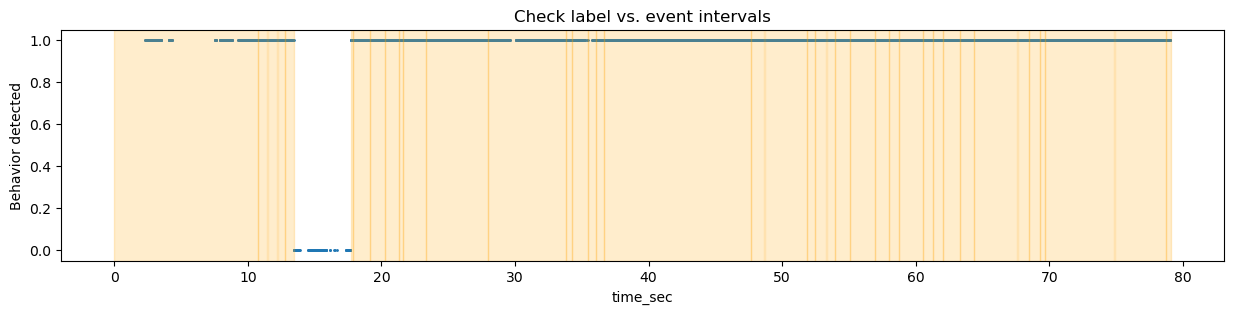

In [8]:
plt.figure(figsize=(15, 3))
plt.scatter(df_wide['time_sec'], df_wide['behavior'].notna(), s=1)
for _, row in df_events.iterrows():
    plt.axvspan(row['start_time'], row['stop_time'], color='orange', alpha=0.2)

plt.xlabel("time_sec")
plt.ylabel("Behavior detected")
plt.title("Check label vs. event intervals")
plt.show()

In [9]:
nan_counts = df_wide.isna().sum()

total_rows = len(df_wide)

nan_report = pd.DataFrame({
    'num_nan': nan_counts,
    'percent_nan': (nan_counts / total_rows) * 100
})

nan_report

,num_nan,percent_nan
frame,0,0.0
time_sec,0,0.0
hand,0,0.0
hand_detected,0,0.0
x_0,0,0.0
...,...,...
z_17,0,0.0
z_18,0,0.0
z_19,0,0.0
z_20,0,0.0


In [10]:
df_wide_clean = df_wide.dropna()

df_wide_clean

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,139,2.317,Left,1,0.739851,0.746795,0.743200,0.732768,0.724978,0.733892,...,-0.029364,0.019300,-0.001943,-0.015308,-0.017748,0.023155,0.008353,0.000929,0.000017,hold
1,140,2.333,Left,1,0.740607,0.752635,0.749488,0.734470,0.726105,0.743083,...,-0.027776,0.018126,-0.004453,-0.016250,-0.016220,0.024569,0.008350,0.001288,0.001831,hold
2,141,2.350,Left,1,0.739510,0.751147,0.748804,0.734133,0.723349,0.739582,...,-0.021573,0.027649,0.006390,-0.009512,-0.012488,0.031582,0.016049,0.006908,0.005533,hold
3,142,2.367,Left,1,0.740625,0.757427,0.754611,0.737037,0.721377,0.744787,...,-0.015998,0.041151,0.017248,-0.004651,-0.010568,0.043575,0.026450,0.013843,0.010108,hold
4,143,2.383,Left,1,0.713443,0.746745,0.755528,0.743631,0.725307,0.753184,...,-0.019736,0.057018,0.030807,-0.000870,-0.012341,0.062581,0.043079,0.023987,0.015717,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345,4739,78.983,Left,1,0.605860,0.577431,0.572069,0.567270,0.560884,0.648888,...,-0.009946,0.008326,0.011651,0.013079,0.015457,0.041377,0.045619,0.046596,0.048374,other
6346,4740,79.000,Left,1,0.607172,0.574205,0.569787,0.565997,0.559199,0.645663,...,0.007201,0.019036,0.024805,0.025153,0.026226,0.050519,0.055929,0.055348,0.055539,other
6347,4741,79.017,Left,1,0.597536,0.567249,0.564755,0.566291,0.562113,0.643634,...,-0.029069,-0.000321,-0.002598,-0.003430,-0.003016,0.034143,0.032199,0.029066,0.027619,other
6348,4742,79.033,Left,1,0.595344,0.563689,0.562409,0.565489,0.562530,0.641024,...,-0.019214,0.006272,0.004897,0.002748,0.002664,0.039182,0.037647,0.033065,0.030840,other


In [11]:
behavior_counts = df_wide_clean['behavior'].value_counts()

print(behavior_counts)

behavior
hold      2778
press     1332
adjust     960
rotate     862
place      275
other       16
Name: count, dtype: int64


In [12]:
df_wide_clean['dataset_id'] = '01-test-01'

cols = df_wide_clean.columns.tolist()
cols = ['dataset_id'] + [col for col in cols if col != 'dataset_id']
df_wide_clean = df_wide_clean[cols]

df_wide_clean

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_26534/1170159022.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wide_clean['dataset_id'] = '01-test-01'


,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,01-test-01,139,2.317,Left,1,0.739851,0.746795,0.743200,0.732768,0.724978,...,-0.029364,0.019300,-0.001943,-0.015308,-0.017748,0.023155,0.008353,0.000929,0.000017,hold
1,01-test-01,140,2.333,Left,1,0.740607,0.752635,0.749488,0.734470,0.726105,...,-0.027776,0.018126,-0.004453,-0.016250,-0.016220,0.024569,0.008350,0.001288,0.001831,hold
2,01-test-01,141,2.350,Left,1,0.739510,0.751147,0.748804,0.734133,0.723349,...,-0.021573,0.027649,0.006390,-0.009512,-0.012488,0.031582,0.016049,0.006908,0.005533,hold
3,01-test-01,142,2.367,Left,1,0.740625,0.757427,0.754611,0.737037,0.721377,...,-0.015998,0.041151,0.017248,-0.004651,-0.010568,0.043575,0.026450,0.013843,0.010108,hold
4,01-test-01,143,2.383,Left,1,0.713443,0.746745,0.755528,0.743631,0.725307,...,-0.019736,0.057018,0.030807,-0.000870,-0.012341,0.062581,0.043079,0.023987,0.015717,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345,01-test-01,4739,78.983,Left,1,0.605860,0.577431,0.572069,0.567270,0.560884,...,-0.009946,0.008326,0.011651,0.013079,0.015457,0.041377,0.045619,0.046596,0.048374,other
6346,01-test-01,4740,79.000,Left,1,0.607172,0.574205,0.569787,0.565997,0.559199,...,0.007201,0.019036,0.024805,0.025153,0.026226,0.050519,0.055929,0.055348,0.055539,other
6347,01-test-01,4741,79.017,Left,1,0.597536,0.567249,0.564755,0.566291,0.562113,...,-0.029069,-0.000321,-0.002598,-0.003430,-0.003016,0.034143,0.032199,0.029066,0.027619,other
6348,01-test-01,4742,79.033,Left,1,0.595344,0.563689,0.562409,0.565489,0.562530,...,-0.019214,0.006272,0.004897,0.002748,0.002664,0.039182,0.037647,0.033065,0.030840,other


In [13]:
df_wide_clean.to_csv("handlandmark_wide_01-test-01.csv", index=False)